# Make GTP

## Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import xarray as xr
import rioxarray
import numpy as np
import pandas as pd
import geopandas as gpd

# Turn off warnings
import warnings
warnings.filterwarnings('ignore')

### Global Parameters
* Global parameters are used in multiple places
* Local parameters should be found above the relevant code

In [2]:
from global_params import *

# Random state for reproducibility
random_state = 11

y_var = ['class_num']

## Step 1: Load data

In [3]:
ds = xr.load_dataset(netcdf_dir+study_area_abbrev+'.nc')

In [4]:
mask = xr.load_dataarray(netcdf_dir+'mask.nc')

In [5]:
# Load the polygon
poly = gpd.read_file(vector_dir+study_area_abbrev+'.geojson')

# Set the crs to 4326, then convert to projected crs
# poly = poly.set_crs(4326).to_crs(crs)
poly = poly.to_crs(crs)

In [6]:
# Put the period names in a list for convenience.
periods = list(ds.period.values)
periods

['Jul 2015', 'Jul 2023']

## Kmeans Classification
Method
* Segement a slice of each period using Kmeans with large k
* Select classes suitable as ground truth point candidates 
  
Based on https://www.analyticsvidhya.com/blog/2019/04/introduction-image-segmentation-techniques-python/

#### Imports

In [7]:
from sklearn import preprocessing
from sklearn.cluster import KMeans

#### Select the variables to use in the classification

In [8]:
list(ds.data_vars.keys())

['nbart_red',
 'nbart_blue',
 'nbart_green',
 'nbart_nir',
 'nbart_swir_1',
 'nbart_swir_2',
 'NDVI',
 'NBR',
 'NDVI_Class',
 'Kmeans_Class',
 'RF_Class']

In [16]:
km_vars = [list(ds.data_vars.keys())[i] for i in [4,3,0]]
km_vars

['nbart_swir_1', 'nbart_nir', 'nbart_red']

### Select the slice of the study area

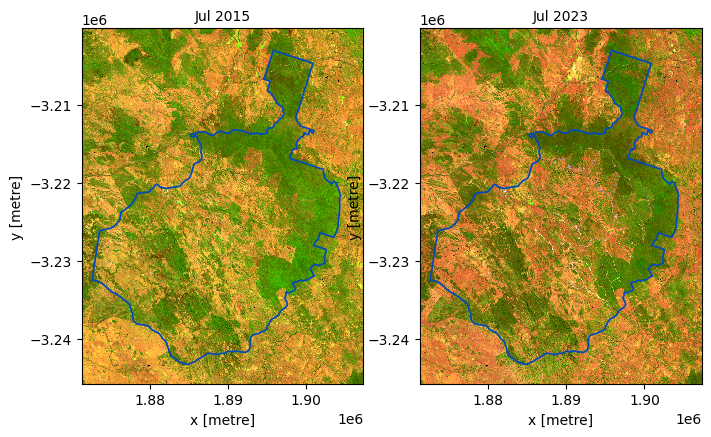

In [17]:
fig, axes = plt.subplots(1,2, figsize=(8,5))

for i, period in enumerate(periods):
    (
     ds[km_vars]
     .sel(period=period)
     .to_array()
     .plot
     .imshow(ax=axes[i], robust=True)
    )
    
    axes[i].set_title(period, fontsize=10)

for i, ax in enumerate(axes.flat):
    poly.boundary.plot(ax=ax, linewidth=1.25, color='#0249ba')

In [19]:
lat_slice=slice(-3.215*1e6,-3.225*1e6)
lat_slice

slice(-3215000.0, -3225000.0, None)

#### Standardise the dataframe

In [20]:
df = ds[km_vars].sel(y=lat_slice).to_dataframe().reset_index(['x','y'], drop=True).drop('spatial_ref', axis=1)

# scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()

x = df[km_vars].values # returns a numpy array
x_norm = scaler.fit_transform(x)
df[km_vars] = x_norm
df.head()

,nbart_swir_1,nbart_nir,nbart_red
period,,,
Jul 2015,-0.138366,0.869816,0.186256
Jul 2015,0.314513,1.077700,0.293336
Jul 2015,0.224220,1.669640,0.179117
Jul 2015,-0.333062,1.444139,-0.192094
Jul 2015,-0.125668,1.222161,-0.252772


In [435]:
# Array to hold the final classifications
km_arrs = [[] for i in [0,1]]

In [21]:
# Sizes for reshaping flattened arrays
w = ds.sel(y=lat_slice).sizes['y']
l = ds.sel(y=lat_slice).sizes['x']

#### Fit on all data for each period

In [45]:
ks = [15,10]
# Set random_state for reproducibility
km = [KMeans(n_clusters=k, random_state = random_state) for k in ks]

In [46]:
km_arrs = [km[i].fit(df.loc[periods[i]]).labels_.reshape(w,l) for i in [0,1]]

#### Plot to check the data

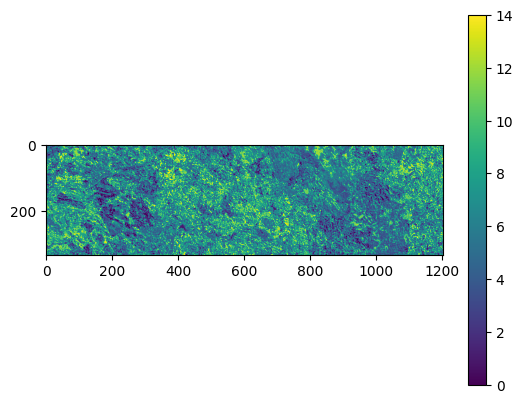

In [47]:
plt.imshow(km_arrs[0])
plt.colorbar()

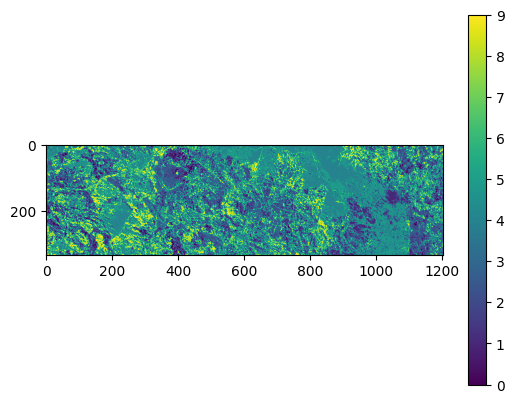

In [44]:
plt.imshow(km_arrs[1])
plt.colorbar()

#### Add the classification data to the dataset

In [48]:
# Convert to int16
km_arrs = np.array(km_arrs, dtype=np.int16)

In [49]:
ds_km = ds[km_vars].sel(y=lat_slice)

In [50]:
ds_km = ds_km.assign({'Kmeans_Class': (('period','y','x'), km_arrs)})

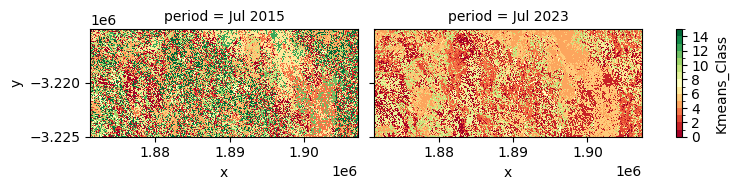

In [51]:
ds_km.Kmeans_Class.plot(col='period', 
                     levels=np.arange(len(np.unique(ds_km.Kmeans_Class))+1),
                     cmap='RdYlGn',
                       figsize=(8,2))

In [52]:
ds_km

<xarray.Dataset>
Dimensions:       (period: 2, y: 333, x: 1204)
Coordinates:
  * y             (y) float64 -3.215e+06 -3.215e+06 ... -3.225e+06 -3.225e+06
  * x             (x) float64 1.871e+06 1.871e+06 ... 1.907e+06 1.907e+06
    spatial_ref   int32 3577
  * period        (period) <U8 'Jul 2015' 'Jul 2023'
Data variables:
    nbart_swir_1  (period, y, x) float32 2.028e+03 2.349e+03 ... 2.432e+03
    nbart_nir     (period, y, x) float32 2.157e+03 2.216e+03 ... 1.674e+03
    nbart_red     (period, y, x) float32 721.0 751.0 719.0 ... 703.0 761.0 786.0
    Kmeans_Class  (period, y, x) int16 13 13 13 8 8 8 8 8 0 ... 2 9 4 9 6 9 3 3

### GeoTIFF - Time steps

Each year is saved with all variables in a geoTIFF file.

**Note**: Converting `to_array()` is essential to avoid "ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''" error.  


In [56]:
for period in periods:
     (ds_km
     .sel(period=period)
     .to_array() # Essential!
     .rio.to_raster(geotiff_dir+study_area_abbrev+'_'+str(period)+'_km_slice.tiff')
     )